<a href="https://colab.research.google.com/github/kd-kdev/CognitiveRadio-LSTM/blob/main/CognitiveRadio_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Cognitive Radio - Channel occupancy prediction using LSTM


Table of contents:
>[PyTorch Cognitive Radio - Channel occupancy prediction using LSTM](#scrollTo=szOWLo_3FYsy)

>>[1. Import libraries & setup](#scrollTo=R-uOLgZWcB4I)

>>[2. Hyperparameters](#scrollTo=8-eDK_jJLcMN)

>>[3. Plotting functions](#scrollTo=T-6tgFbULffj)

>>[4. Simulate channel data](#scrollTo=gVkPvKYpLuhe)

>>[5. Sequence creation & DataLoader](#scrollTo=7-D_fGKNL6Jz)

>>[6. LSTM model definition](#scrollTo=NXTUz7rOMFLL)

>>[7. Training loop](#scrollTo=RHSHqKGMMUZw)

>>[8. Evaluate model on new dataset](#scrollTo=0AvRdlELMbBy)

>>[TESTING](#scrollTo=E4AbDAiDDDXI)



## 1.&nbsp;Import libraries & setup
Imports all related libraries & installs packages (includes optional visualization libs), may require re-run after runtime restart.

In [14]:
import importlib
def ensure(pkg, pip_name=None):
    pip_name = pip_name or pkg
    try:
        importlib.import_module(pkg)
        print(f"{pkg} already installed.")
    except ImportError:
        print(f"Installing {pip_name}...")
        !pip install -q {pip_name}

ensure("torchview")
ensure("torchviz")
ensure("torch_summary", "torch-summary")
ensure("seaborn")

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchview import draw_graph
from torchsummary import summary


DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', DEVICE)

torchview already installed.
torchviz already installed.
Installing torch-summary...
seaborn already installed.
Using device: cuda


## 2.&nbsp;Hyperparameters
Central config dictionary - change values here

In [15]:
config = {
    'num_channels': 5,
    'signal_length': 1000,
    'input_window': 100,
    'horizon': 10,
    'hidden_size': 256,
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 0.001,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

config

{'num_channels': 5,
 'signal_length': 1000,
 'input_window': 100,
 'horizon': 10,
 'hidden_size': 256,
 'batch_size': 64,
 'num_epochs': 100,
 'learning_rate': 0.001,
 'device': device(type='cuda')}

## 3.&nbsp;Plotting functions
Contains functions that produce a plot, used later in code for data visualization.

In [79]:
def plot_channels(channel_data, num_channels):
    plt.figure(figsize=(14, 4))

    offset = 1.5
    yticks = []
    yticklabels = []

    for i in range(num_channels):
        rev_i = num_channels - 1 - i
        channel_offset = rev_i * offset

        # Plot actual channel signal
        plt.plot(channel_data[i] + channel_offset, label=f"Channel {i+1}")

        # Add horizontal lines at 0 and 1 for this channel
        plt.hlines(y=channel_offset + 0, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)
        plt.hlines(y=channel_offset + 1, xmin=0, xmax=channel_data.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Set middle point for tick
        mid = channel_offset + 0.5
        yticks.append(mid)
        yticklabels.append(f"Ch {i+1}")

    plt.title("Simulated Channel Occupancy")
    plt.xlabel("Time step")
    plt.ylabel("Occupancy")
    plt.yticks(yticks, yticklabels)
    plt.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)
    plt.grid(True)
    plt.show()

def plot_loss(loss_values, num_epochs):
    min_loss_value = min(loss_values)
    min_loss_epoch = loss_values.index(min_loss_value) + 1  # +1 because num_epochs start at 1
    max_loss_value = max(loss_values)
    last_loss_value = loss_values[num_epochs-1]
    # Loss curve plot with best loss highlighted
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', label='Training Loss')

    # Highlight the best loss
    plt.plot(min_loss_epoch, min_loss_value, 'ro', label='Best Loss')
    plt.annotate(f'Best: {min_loss_value:.4f}',
                xy=(min_loss_epoch, min_loss_value),
                xytext=(min_loss_epoch + 1, min_loss_value + 0.01),
                arrowprops=dict(facecolor='red', arrowstyle='->'))

    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_compact_comparison(X_raw, preds_binary):
    # preds_binary is already numpy, no need for .cpu().numpy()
    preds_np = preds_binary
    num_samples, horizon, num_channels = preds_np.shape

    # Initialize array for full length predictions
    pred_full = np.zeros((num_channels, X_raw.shape[1]))

    # slide horizon predictions over time
    for i in range(num_samples):
        start_idx = i
        end_idx = i + horizon
        if end_idx > X_raw.shape[1]:
            end_idx = X_raw.shape[1]
        signal_length = end_idx - start_idx
        pred_full[:, start_idx:end_idx] = preds_np[i, :signal_length, :].T


    num_channels = X_raw.shape[0]

    fig, axes = plt.subplots(num_channels, 1, figsize=(17, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]
        ax.plot(X_raw[i], label=f"Actual", linewidth=2)
        ax.plot(pred_full[i], '--', label=f"Predicted", linewidth=2)
        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)  # keep 0-1 range
        ax.set_yticks([0, 1])  # only show 0 and 1
        ax.set_title(f"Channel {i+1}")
        ax.grid(True)
        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()


def plot_full_comparison(X_raw, pred_full):
    # Stitches together the 891x10x5 predictions into a 1000-step long prediction signal for each channel
    # usable timeline

    # Wider graph with more detail
    num_channels = X_raw.shape[0]
    fig, axes = plt.subplots(num_channels, 1, figsize=(35, 2*num_channels), sharex=False)

    for i in range(num_channels):
        ax = axes[i]

        # Solid line for actual
        ax.plot(X_raw[i], label=f"Channel {i+1} Actual", linewidth=2)

        # Dashed line for predicted
        ax.plot(pred_full[i], '--', label=f"Channel {i+1} Predicted", linewidth=2)

        ax.set_ylabel("Occupancy")
        ax.set_ylim(-0.1, 1.1)
        ax.set_yticks([0, 1])
        ax.set_title(f"Channel {i+1}")

        # Horizontal 0/1 guide lines
        ax.hlines([0, 1], xmin=0, xmax=X_raw.shape[1]-1, colors='gray', linestyles='dashed', linewidth=0.8)

        # Vertical guidelines
        ax.set_xticks(np.arange(0, X_raw.shape[1]+1, 50))
        ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)

        ax.legend(loc='upper left', bbox_to_anchor=(1.01, 1), borderaxespad=0)

        # Remove horizontal padding
        ax.margins(x=0.01)

    axes[-1].set_xlabel("Time step")
    plt.tight_layout()
    plt.show()

def heatmap_subgraphed_correctness(X_raw, pred_full):
    # HEATMAP - Subgraphed for every 200 steps

    pred_full_np = pred_full       # shape (5, T)
    X_raw_np = X_raw               # shape (5, T)

    # Ensure binary predictions
    pred_bin = (pred_full_np >= 0.5).astype(int)

    # Correctness matrix: 1 = correct, 0 = incorrect
    correct_matrix = (pred_bin == X_raw_np).astype(int)

    segment_length = 200
    time_steps = correct_matrix.shape[1]
    num_segments = (time_steps + segment_length - 1) // segment_length  # ceil division

    plt.figure(figsize=(30, num_segments * 3))  # height scales per segment

    for seg in range(num_segments):
        start = seg * segment_length
        end = min(start + segment_length, time_steps)

        ax = plt.subplot(num_segments, 1, seg + 1)

        sns.heatmap(
            correct_matrix[:, start:end],
            cmap=["#d9534f", "#5cb85c"],   # red = incorrect, green = correct
            cbar=False,
            linewidths=1,
            linecolor="black",
            square=True
        )

        ax.set_ylabel("Channel", fontsize=14)
        ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
        ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], fontsize=10)

        ax.set_xticks(np.arange(0, end - start, 50))
        ax.set_xticklabels(np.arange(start, end, 50), rotation=90, fontsize=10)

        ax.set_title(f"Time Steps {start} → {end}", fontsize=16, pad=12)

    plt.xlabel("Time Step", fontsize=16)
    plt.tight_layout()
    plt.show()

def heatmap_full_correctness(X_raw, pred_full):
    # HEATMAP - One long scrollable axis

    pred_full_np = pred_full       # shape (5, time_steps)
    X_raw_np = X_raw               # shape (5, time_steps)

    # Ensure binary predictions
    pred_bin = (pred_full_np >= 0.5).astype(int)

    # Correctness matrix: 1 = correct, 0 = incorrect
    correct_matrix = (pred_bin == X_raw_np).astype(int)

    # Make blocks big + scrollable
    plt.figure(figsize=(400, 50))

    ax = sns.heatmap(
        correct_matrix,
        cmap=["#d9534f", "#5cb85c"],   # red = incorrect, green = correct
        cbar=False,
        linewidths=1,
        linecolor="black",
        square=True  # ensures blocks are large squares
    )

    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], fontsize=12)

    # Reduce xtick clutter: only show every 50th time step
    ax.set_xticks(np.arange(0, correct_matrix.shape[1], 50))
    ax.set_xticklabels(np.arange(0, correct_matrix.shape[1], 50), rotation=90, fontsize=10)

    plt.title("Prediction Accuracy Heatmap (Large, Scrollable)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()

def heatmap_full_correctness_first200(X_raw, pred_full, steps=200):
    # Take only the first `steps` time steps
    X_raw_np = X_raw[:, :steps]         # shape (num_channels, steps)
    pred_full_np = pred_full[:, :steps] # shape (num_channels, steps)

    # Ensure binary predictions
    pred_bin = (pred_full_np >= 0.5).astype(int)

    # Correctness matrix: 1 = correct, 0 = incorrect
    correct_matrix = (pred_bin == X_raw_np).astype(int)

    # Large blocks for readability
    plt.figure(figsize=(16, 8))

    ax = sns.heatmap(
        correct_matrix,
        cmap=["#d9534f", "#5cb85c"],   # red = incorrect, green = correct
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )

    ax.set_xlabel("Time step", fontsize=12)
    ax.set_ylabel("Channel", fontsize=12)

    ax.set_yticks(np.arange(correct_matrix.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(correct_matrix.shape[0])], rotation=90, fontsize=6)

    # Add the last tick if it's not already included
    # Reduce x-tick clutter: show every 20th step
    x_ticks = list(np.arange(0, correct_matrix.shape[1], 20))

    # Ensure the last column is included
    if (correct_matrix.shape[1]) not in x_ticks:
        x_ticks.append(correct_matrix.shape[1])  # last index is steps-1

    ax.set_xticks(x_ticks)
    ax.set_xticklabels([str(tick) for tick in x_ticks], rotation=90, fontsize=10)  # +1 if you want 1-based labels


    plt.title(f"Prediction Accuracy Heatmap (First {steps} Steps)", fontsize=18, pad=20)
    plt.tight_layout()
    plt.show()



def heatmap_dataset_sample_binary(X, y, sample_index=0, input_window=100, horizon=10):
    marker_position = input_window + horizon  # 110
    # Select the sample
    X_sample = X[sample_index]
    y_sample = y[sample_index]

    # Combine input and horizon along time axis
    combined = np.concatenate([X_sample, y_sample], axis=0).T  # shape -> (5, 110)
    plt.figure(figsize=(13, 8))

    ax = sns.heatmap(
        combined,
        cmap=["#d9534f", "#5cb85c"],
        cbar=False,
        linewidths=0.5,
        linecolor="black",
        square=True
    )
    ax.set_xlabel("Time step", fontsize=16)
    ax.set_ylabel("Channel", fontsize=16)

    # Channels
    ax.set_yticks(np.arange(combined.shape[0]) + 0.5)
    ax.set_yticklabels([str(i+1) for i in range(combined.shape[0])], fontsize=6)

    # Vertical line separating input and horizon
    ax.axvline(input_window, color="black", linewidth=4)
    ax.text(input_window + 0.5, -0.5, "←Horizon→", fontsize=10, color="black")

    # Reduce x-tick clutter
    ax.set_xticks(np.arange(0, combined.shape[1], 10))
    ax.set_xticklabels(np.arange(0, combined.shape[1], 10), rotation=90)

    # Ensure 110 is included as a tick and appears below the heatmap
    xticks = list(np.arange(0, combined.shape[1], 10))
    if marker_position not in xticks:
        xticks.append(marker_position)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(t) for t in xticks], rotation=90)

    # Thick vertical line at 110
    ax.axvline(marker_position, color='black', linewidth=3)
    plt.title(f"Dataset Sample #{sample_index}", fontsize=16, pad=20)

    # Define legend entries
    legend_elements = [
        Patch(facecolor='#d9534f', edgecolor='black', label='0'),
        Patch(facecolor='#5cb85c', edgecolor='black', label='1')
    ]
    # Add legend to the axes
    ax.legend(handles=legend_elements, title='Value', loc='upper right', bbox_to_anchor=(1.08, 1.2))
    plt.tight_layout()
    plt.show()

## 4.&nbsp;Simulate channel data
Simulates channels - Return array shape (num_channels, length) with 0/1 occupancy.

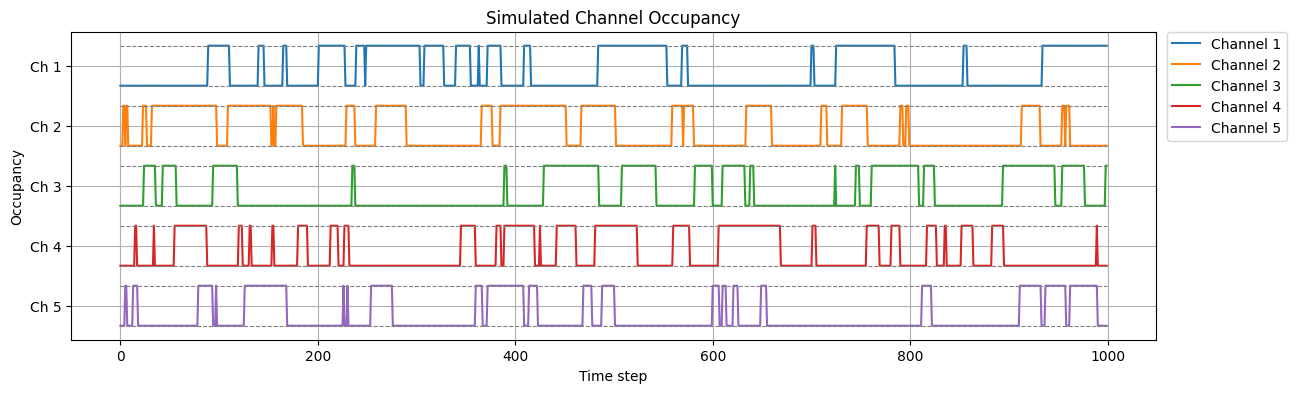

In [17]:
def simulate_multiple_channels(num_channels=config['num_channels'], signal_length=config['signal_length'], avg_on_duration=20, avg_off_duration=30):
    channels = []
    for _ in range(num_channels):
        channel = []
        state = 0
        while len(channel) < signal_length:
            duration = np.random.exponential(scale=avg_on_duration if state == 1 else avg_off_duration)
            duration = int(max(1, round(duration)))
            channel.extend([state] * duration)
            state = 1 - state
        channels.append(channel[:signal_length])
    return np.array(channels)

channel_data = simulate_multiple_channels()
plot_channels(channel_data, config['num_channels'])

## 5.&nbsp;Sequence creation & DataLoader
Converts channel data into X y sliding windows & creates PyTorch DataLoader

In [18]:
channel_data = channel_data.T # this transposes it to shape (time_steps, num_channels) for sequence slicing

def create_sequence(channel_data, input_window=100, horizon=10):
  X = [] # sequence of past channel states, contains a fixed length window of past observations
  y = [] # sequence of steps after 10 steps (horizon, the num. of steps in the future we want to predict)
  for i in range(len(channel_data) - input_window - horizon +1):
    X.append(channel_data[i:i+input_window])
    y.append(channel_data[i+input_window : i+input_window+horizon])
  return np.array(X), np.array(y)

X, y = create_sequence(channel_data, input_window=100, horizon=10)
print(f"X.shape = {X.shape}, y.shape = {y.shape}")
# will give you 891 training samples from the dataset, 100 time steps, 5 values per channel

# DataLoader part
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)

batch_size = 64 # try out different values like 32 as well
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

X.shape = (891, 100, 5), y.shape = (891, 10, 5)


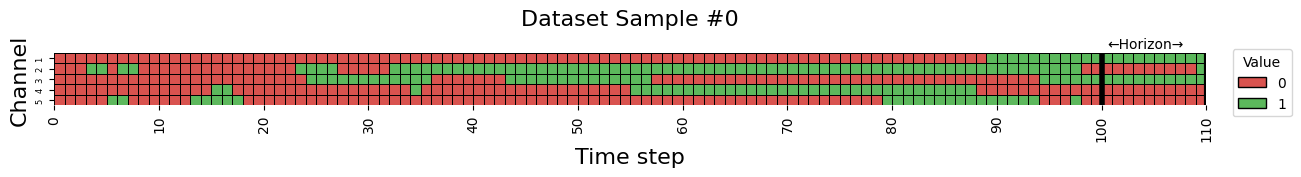

In [19]:
# Show heatmap sample from dataset
heatmap_dataset_sample_binary(X, y, sample_index=0)


## 6.&nbsp;LSTM model definition
Defines the LSTM model

In [20]:
class LSTM_model(nn.Module):
    def __init__(self, num_channels, horizon=10, hidden_size=256):
        super().__init__()

        self.horizon = horizon # number of future time steps to predict
        self.num_channels = num_channels # number of channels/features in each input time step

        self.lstm = nn.LSTM( # defines the LSTM layer:
            input_size=num_channels, # input_size = num_channels: dimensionality of each input vector per time step (e.g., 5 channels)
            hidden_size=hidden_size, # hidden_size = 256: dimensionality of the hidden state
            batch_first=True # batch_first=True: input and output tensors have shape (batch, sequence_length, features)
        )
        self.fc = nn.Linear( # defines the fully connected (Linear) layer:
            hidden_size, # maps the final LSTM hidden state of size (hidden_size) to the prediction of 'horizon' future steps for each channel
            num_channels * horizon
        )

    def forward(self, x):  # x: (batch_size, 100, 5)
        out, _ = self.lstm(x) # out: (batch_size, 100, 256)
        last_out = out[:, -1, :] # last_out: (batch_size, 256)
        preds = self.fc(last_out) # preds: (batch_size, 10*5) = (batch_size, 50)
        preds = preds.view(-1, self.horizon, self.num_channels) # preds: (batch_size, 10, 5)
        return torch.sigmoid(preds) # returns probabilities in range [0,1]


## 7.&nbsp;Training loop
Training loop for model

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training Parameters
num_channels = X.shape[2]  # 5 channels
horizon = y.shape[1]       # 10 time steps ahead
loss_values = []
#epochs = 100
#lr = 0.001 # learning rate

model = LSTM_model(num_channels=num_channels, horizon=horizon)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])
criterion = nn.BCELoss()

# Variable to track best loss
best_loss = float('inf')
best_model_state = None  # to store the best model

# Training loop
for epoch in range(1, config['num_epochs'] +1):
  model.train()
  epoch_loss = 0.0

  for X_batch, y_batch in dataloader:
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    optimizer.zero_grad()
    outputs = model(X_batch)
    loss = criterion(outputs, y_batch)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() * X_batch.size(0)

  avg_loss = epoch_loss / len(dataset)
  loss_values.append(avg_loss)
  print(f"Epoch {epoch}/{config['num_epochs']} - Loss: {avg_loss:.4f}")

  # Save best model
  if avg_loss < best_loss:
        best_loss = avg_loss
        best_model_state = model.state_dict()  # save model weights
        #print(f"  --> New best loss, saving model.")

# load the best model
model.load_state_dict(best_model_state)
print(f"Training complete. Best loss: {best_loss:.4f}")

Epoch 1/100 - Loss: 0.6645
Epoch 2/100 - Loss: 0.6198
Epoch 3/100 - Loss: 0.5886
Epoch 4/100 - Loss: 0.5533
Epoch 5/100 - Loss: 0.5219
Epoch 6/100 - Loss: 0.5009
Epoch 7/100 - Loss: 0.4698
Epoch 8/100 - Loss: 0.4444
Epoch 9/100 - Loss: 0.4170
Epoch 10/100 - Loss: 0.4367
Epoch 11/100 - Loss: 0.4036
Epoch 12/100 - Loss: 0.3701
Epoch 13/100 - Loss: 0.3531
Epoch 14/100 - Loss: 0.3473
Epoch 15/100 - Loss: 0.4004
Epoch 16/100 - Loss: 0.3685
Epoch 17/100 - Loss: 0.3343
Epoch 18/100 - Loss: 0.3093
Epoch 19/100 - Loss: 0.3155
Epoch 20/100 - Loss: 0.3091
Epoch 21/100 - Loss: 0.2830
Epoch 22/100 - Loss: 0.2637
Epoch 23/100 - Loss: 0.2786
Epoch 24/100 - Loss: 0.3567
Epoch 25/100 - Loss: 0.3062
Epoch 26/100 - Loss: 0.3573
Epoch 27/100 - Loss: 0.3079
Epoch 28/100 - Loss: 0.2710
Epoch 29/100 - Loss: 0.2424
Epoch 30/100 - Loss: 0.2278
Epoch 31/100 - Loss: 0.2164
Epoch 32/100 - Loss: 0.2053
Epoch 33/100 - Loss: 0.2325
Epoch 34/100 - Loss: 0.2324
Epoch 35/100 - Loss: 0.2047
Epoch 36/100 - Loss: 0.1869
E

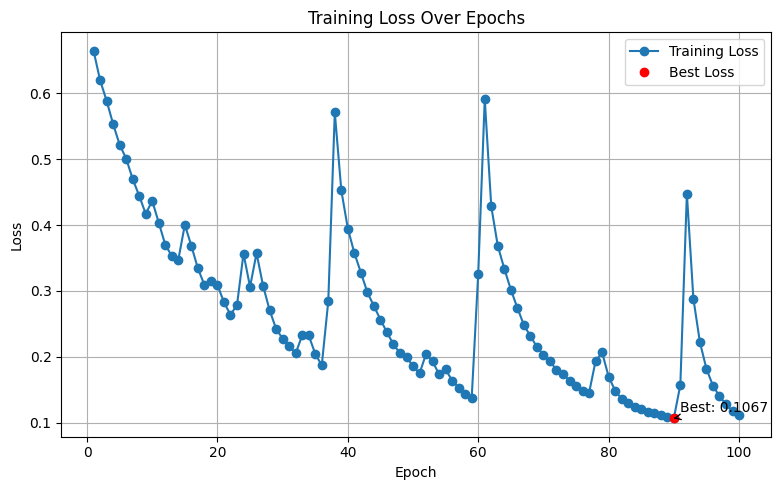

In [22]:
plot_loss(loss_values, config['num_epochs'])

## 8.&nbsp;Evaluate model on new dataset
Evaluates the trained model on multiple (num_tests) new datasets (generated using `simulate_multiple_channels`)

In [55]:
def new_data():
    random_avg_on = random.randint(1, 100)
    random_avg_off = random.randint(1, 100)

    X_raw = simulate_multiple_channels(
        num_channels=5,
        signal_length=1000,
        avg_on_duration=random_avg_on,
        avg_off_duration=random_avg_off
    )

    X_raw_T = X_raw.T

    # debug prints
    #print(f"Generated test data with values:")
    #print(f"avg_on_duration: {random_avg_on}")
    #print(f"avg_off_duration: {random_avg_off}")

    input_window = 100
    horizon = 10
    test_X, test_y = create_sequence(X_raw_T, input_window, horizon)

    test_X_tensor = torch.tensor(test_X, dtype=torch.float32).to(device)
    test_y_tensor = torch.tensor(test_y, dtype=torch.float32).to(device)

    return test_X_tensor, test_y_tensor, X_raw_T, random_avg_on, random_avg_off


def run_tests(num_tests):

    rows = []
    saved_results = []

    model.load_state_dict(best_model_state)
    model.to(device)
    model.eval()
    print(f"Loaded best model with loss: {best_loss:.4f}")

    for i in range(num_tests):
        test_X_tensor, test_y_tensor, X_raw_T, avg_on, avg_off = new_data()

        with torch.no_grad():
            preds = model(test_X_tensor)

        preds_binary = (preds >= 0.5).int()

        correct = (preds_binary == test_y_tensor.int()).sum().item()
        total = torch.numel(test_y_tensor)
        acc_percent = (correct / total) * 100

        # reconstruct full-length prediction here
        pred_full, X_raw = reconstruct_full_prediction(preds_binary, X_raw_T, horizon=10)

        # store for later use (plotting, analysis, etc.)
        saved_results.append((pred_full, X_raw, preds_binary.cpu().numpy(), avg_on, avg_off, acc_percent))

        rows.append(f"{i+1:02d}\t{avg_on}\t{avg_off}\t{acc_percent:.2f}")

    print("Test\tavg_on_duration\tavg_off_duration\tAccuracy (%)")
    for r in rows:
        print(r)

    return rows, saved_results

def reconstruct_full_prediction(preds_binary, X_raw_T, horizon=10):
    """
    Reconstruct full-length prediction from overlapping windows.

    preds_binary: torch.Tensor of shape (num_samples, horizon, num_channels)
    X_raw_T: numpy array (time_steps, num_channels)
    horizon: steps predicted per input sequence

    Returns:
        pred_full: numpy array (num_channels, signal_length)
        X_raw: numpy array (num_channels, signal_length)
    """

    preds_np = preds_binary.cpu().numpy()  # (num_samples, horizon, num_channels)
    num_samples, horizon, num_channels = preds_np.shape

    # Reconstruct the original signal orientation (num_channels, signal_length)
    X_raw = X_raw_T.T  # (time_steps, channels) -> (channels, time_steps)
    signal_length = X_raw.shape[1]

    pred_full = np.zeros((num_channels, signal_length))

    for i in range(num_samples):
        start = i
        end = min(i + horizon, signal_length)
        pred_full[:, start:end] = preds_np[i, :end-start, :].T

    return pred_full, X_raw

# Calls
table, results = run_tests(20)
pred_full, X_raw, preds_binary, avg_on, avg_off, acc = results[0] # store the data from test #1

Loaded best model with loss: 0.1067
Test	avg_on_duration	avg_off_duration	Accuracy (%)
01	36	56	70.12
02	81	80	61.63
03	83	2	71.54
04	23	14	58.20
05	2	12	72.77
06	84	23	58.35
07	26	32	65.20
08	32	31	60.73
09	50	79	74.11
10	89	58	71.70
11	44	48	66.72
12	31	98	73.61
13	16	100	78.40
14	32	63	70.92
15	34	65	65.52
16	66	86	66.36
17	32	98	70.44
18	68	11	58.04
19	98	79	62.87
20	19	4	53.65


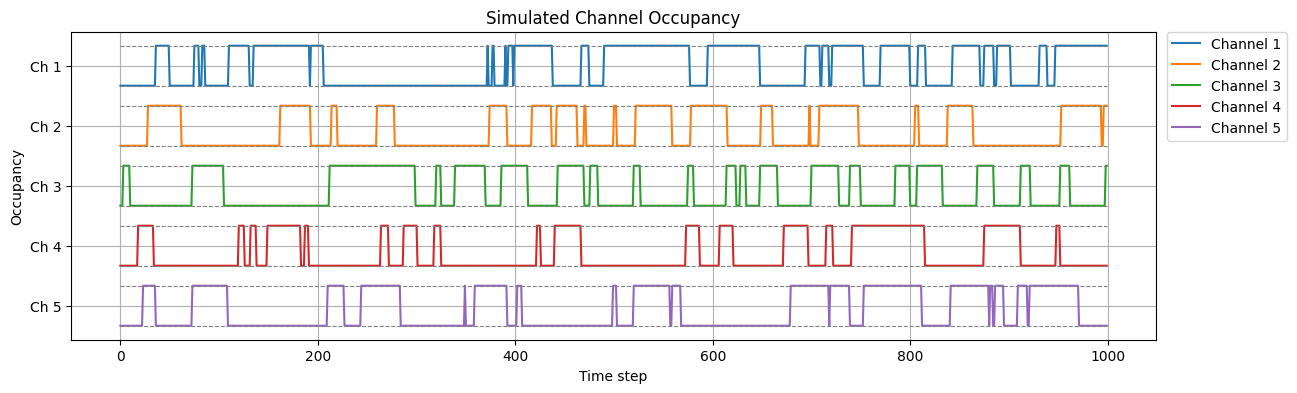

In [50]:
# show new dataset in plot
channel_data = simulate_multiple_channels()
plot_channels(channel_data, num_channels)

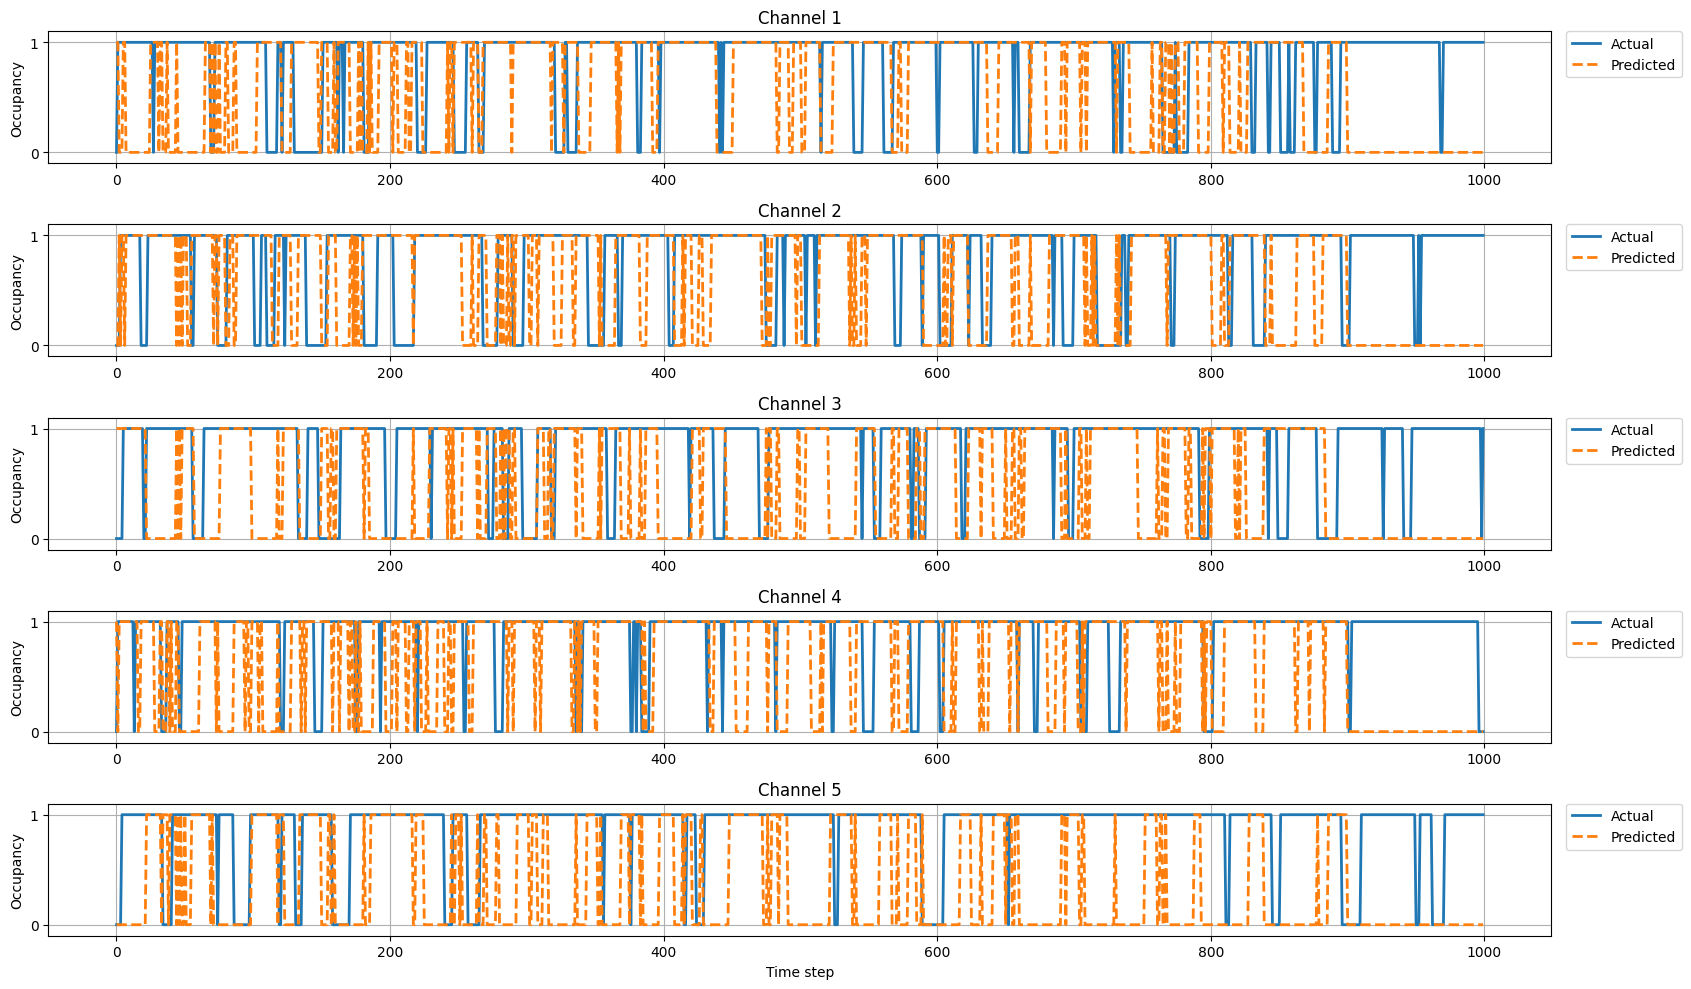

In [51]:
# compact comparison plot
plot_compact_comparison(X_raw, preds_binary)

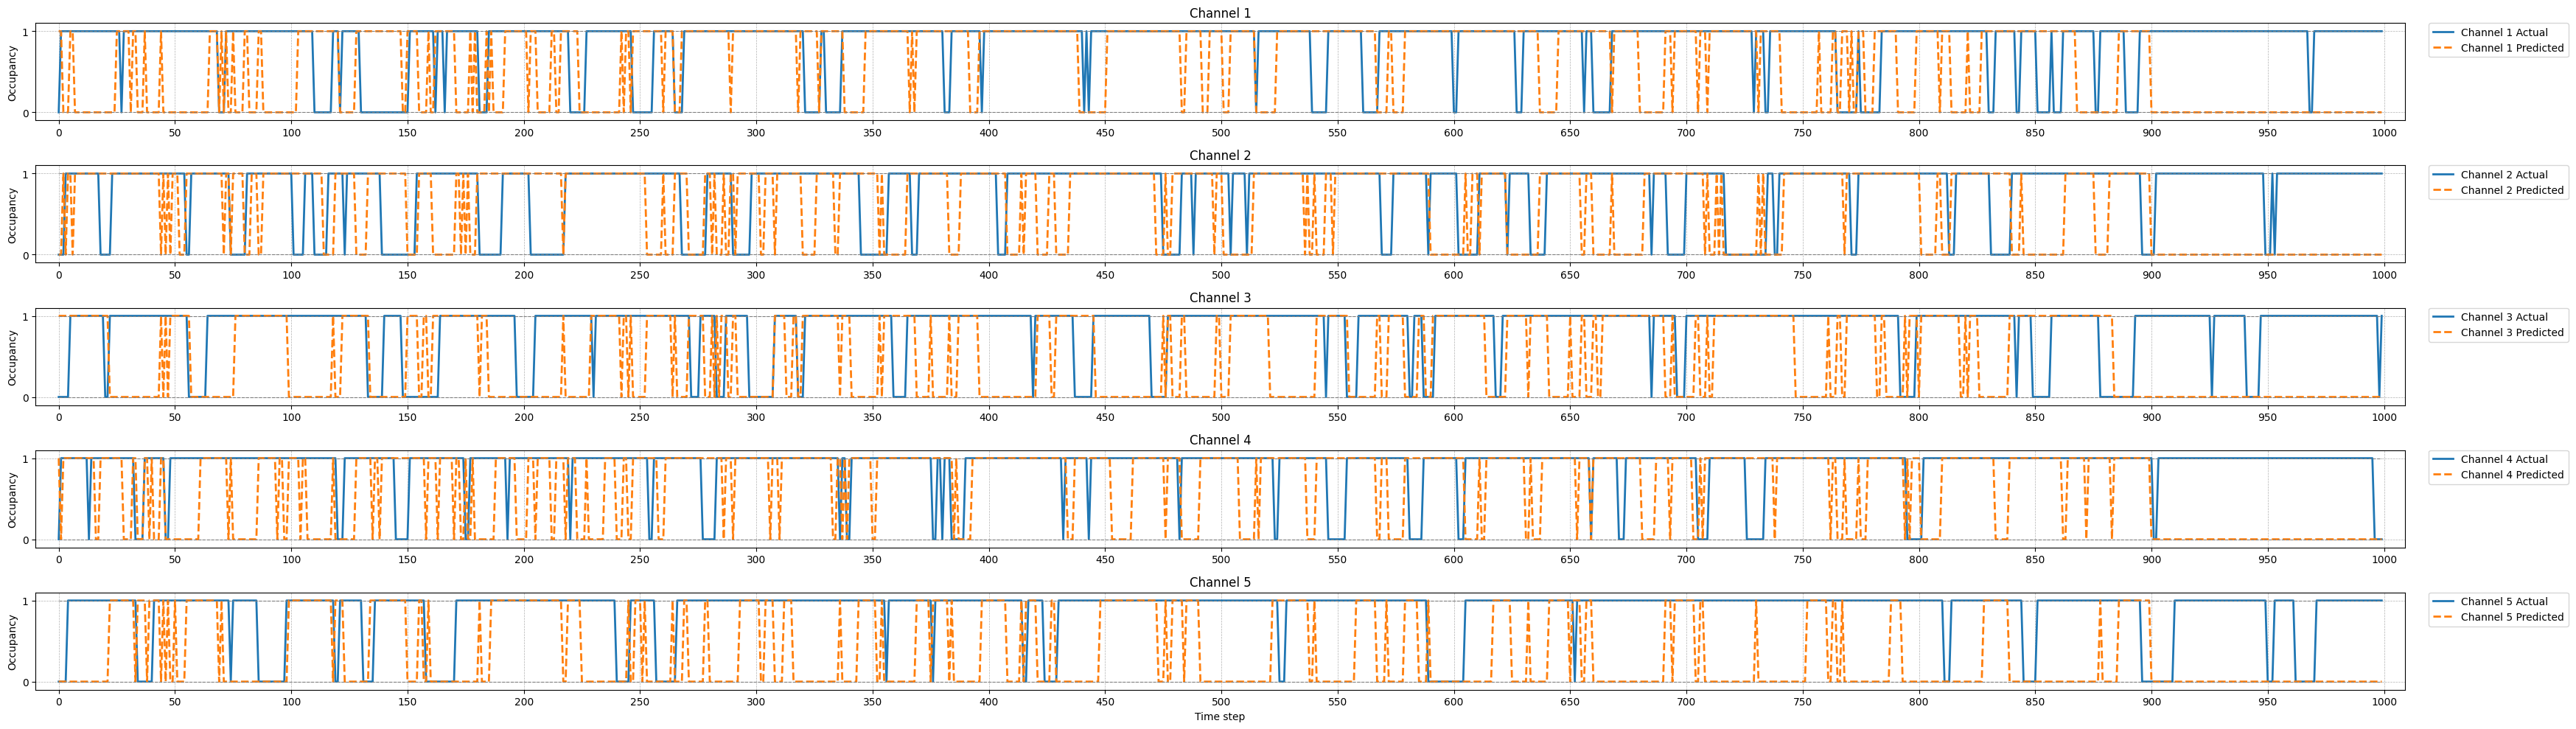

In [52]:
# full comparison plot
plot_full_comparison(X_raw, pred_full)

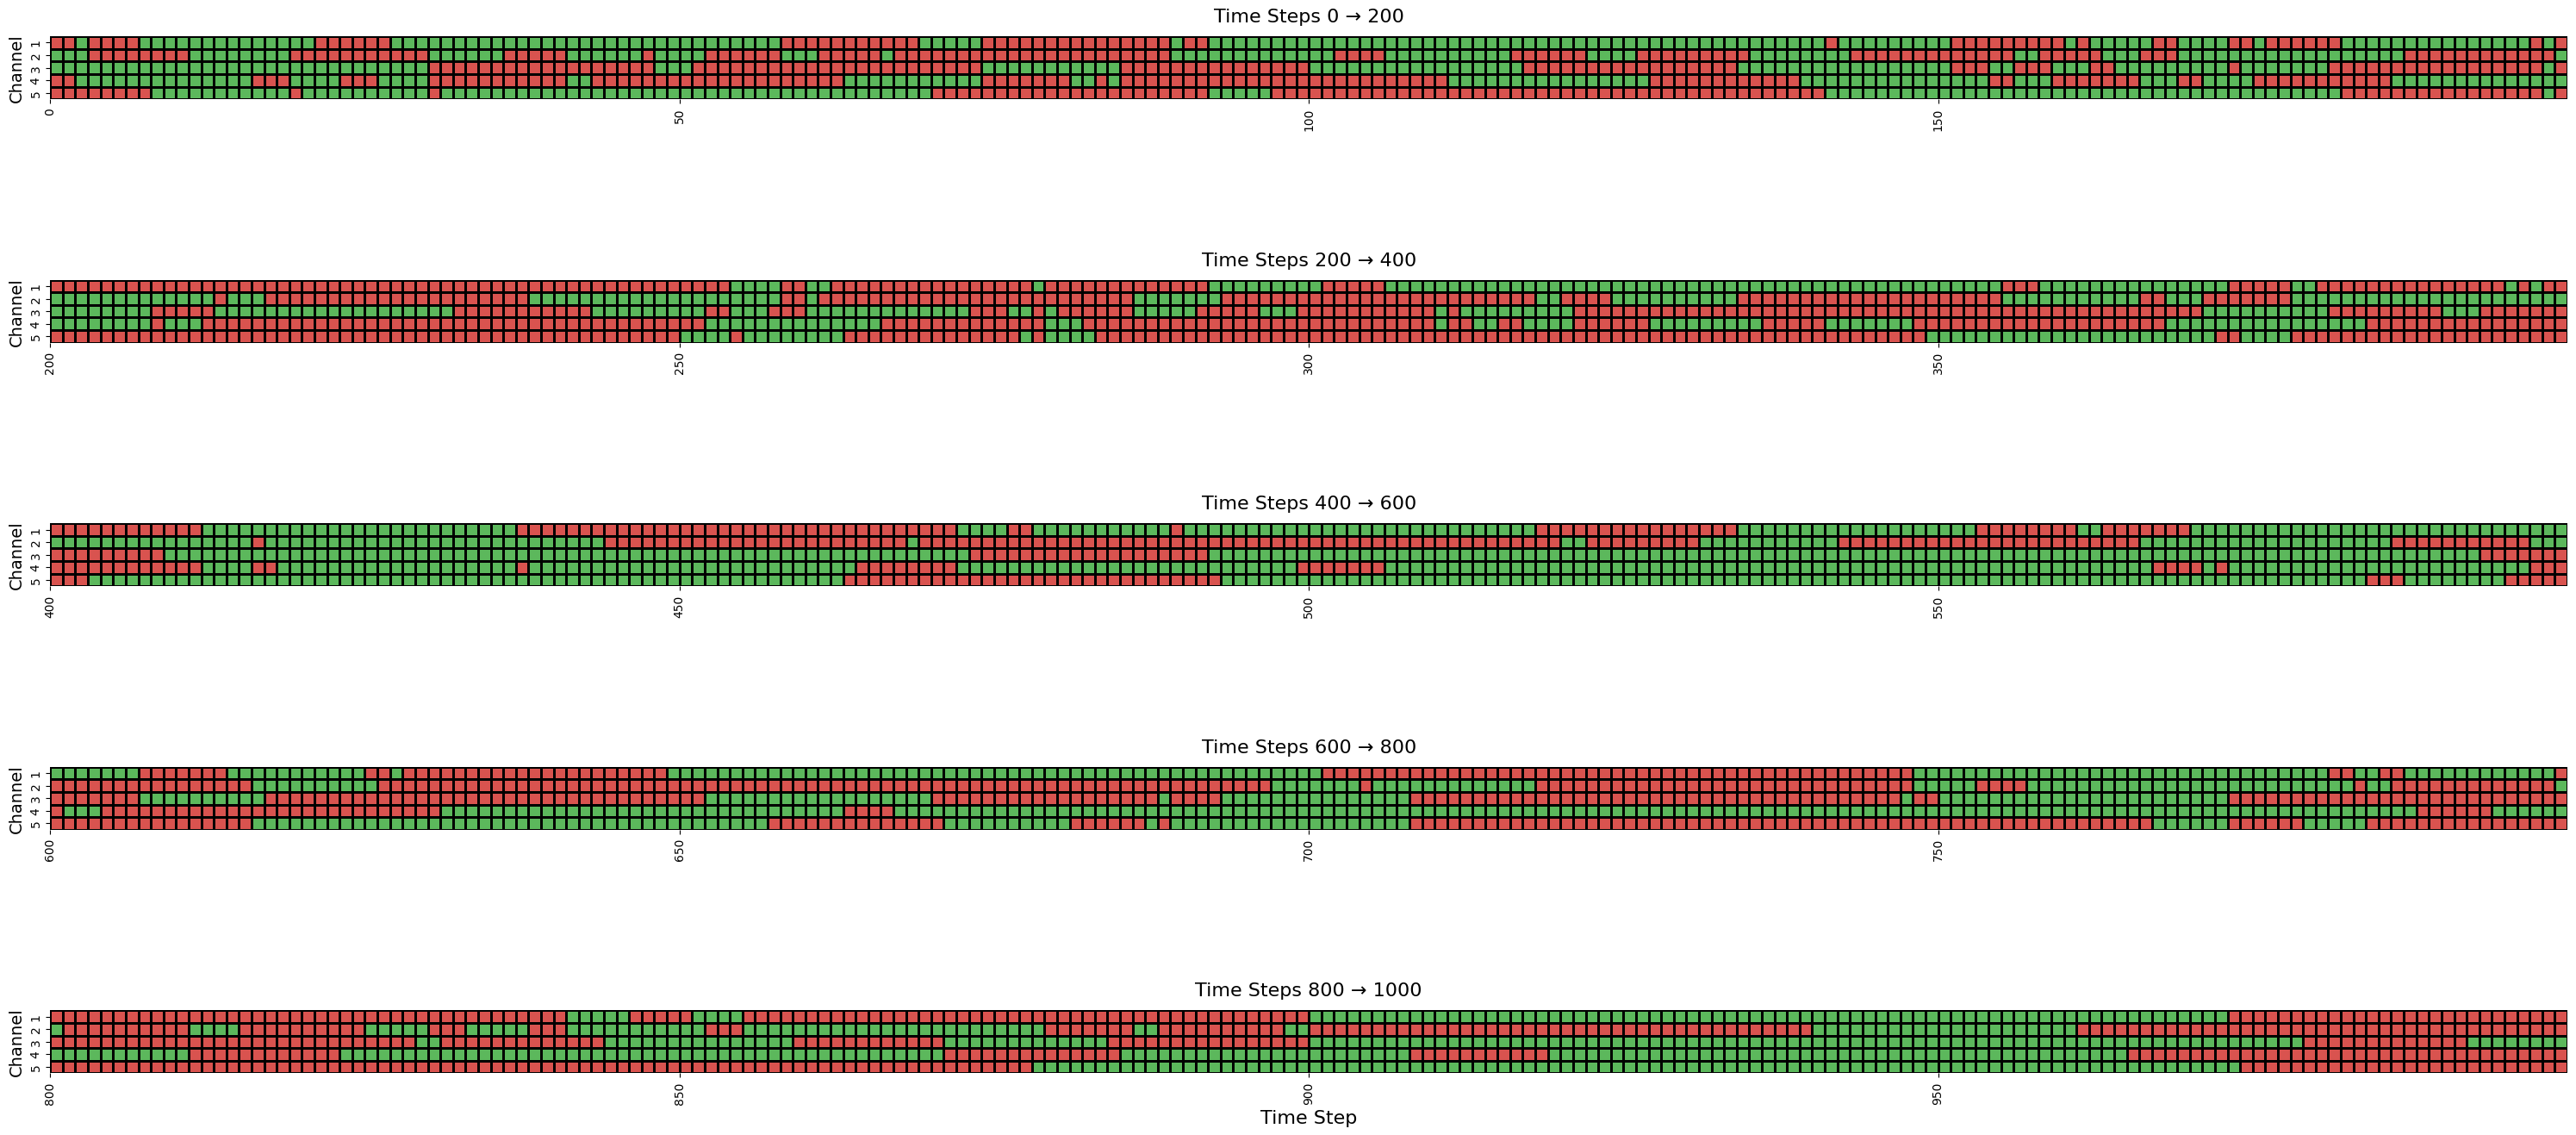

In [56]:
# heatmap subgraph
heatmap_subgraphed_correctness(X_raw, pred_full)

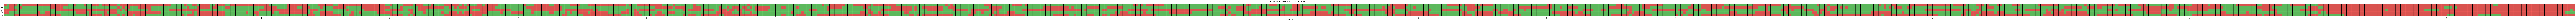

In [54]:
# heatmap full
heatmap_full_correctness(X_raw, pred_full)

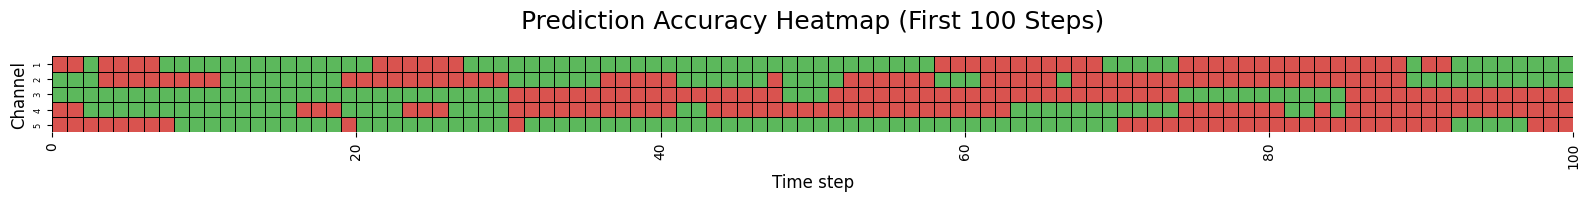

In [81]:
# heatmap first 200 compact
heatmap_full_correctness_first200(X_raw, pred_full, steps=100)

## TEST

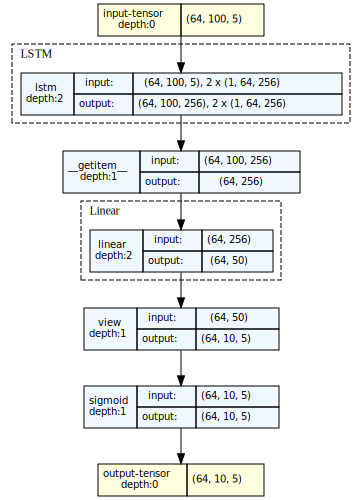

In [41]:
# torchviz
# Model and input setup
num_channels = 5
horizon = 10
hidden_size = 256
batch_size = 64
seq_length = 100

model = LSTM_model(num_channels=num_channels, horizon=config['horizon'], hidden_size=config['hidden_size'])

# Generate the clean model graph with output shapes
graph = draw_graph(
    model,
    input_size=(batch_size, seq_length, num_channels),  # Input shape: [64, 100, 5]
    device="cpu",
    expand_nested=True,
    depth=3,
    save_graph=True,
    graph_name="lstm_training_flow",
    hide_module_functions=False
)

graph.visual_graph

In [42]:
# torchinfo
summary(model)

Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─LSTM: 1-1                              269,312
├─Linear: 1-2                            12,850
Total params: 282,162
Trainable params: 282,162
Non-trainable params: 0